### Instructions

- We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
> 
Make a datetime index using the Date column with a business day frequency('B)
> 
Check for and address null values
> .
Check the time series for stationarit
> y.
Determine the number of differencn (d) needed to make the data stationay. 
(We recommend using pmdarima's ndf
> fs)
Use ACF/PACF plots of the stationary data to estimate initial time series m
odel ordrs​ (,
> d,q)
Split the time series into training and test data. Use a test_size of one q:urter (13 weeks X 5 busines
 > days)
Fit an ARIMA model based on the orders determined during your explor
> ation.
Make forecasts with your
>  model.
Plot the forecasts versus the te
> st data.
Obtain metrics for ev
> aluation.
Try at least one variation of the model for, omparison (we recommend using a loop to try combinations of md
> el orders)
A MAPE of less than 2% on the test data is <br> 
 <br>
    - achievable.
Choose a final model         - and explain:
How good was your model, according to your Mean Absolute Perc        - entage Error?
How good was your model in terms of how well the forecast seems to follow the test daa, visually?  (Hint: You may want to plot fewer training data lgs to see this)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
import pandas as pd
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

## Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

## Load Data

In [6]:
ts = pd.read_csv("WMT.csv", parse_dates=['Date'], index_col='Date')
ts.head()

Adj Close
Date                 
2000-01-03  44.915394
2000-01-04  43.234756
2000-01-05  42.352402
2000-01-06  42.814564
2000-01-07  46.049828

<Axes: xlabel='Date'>

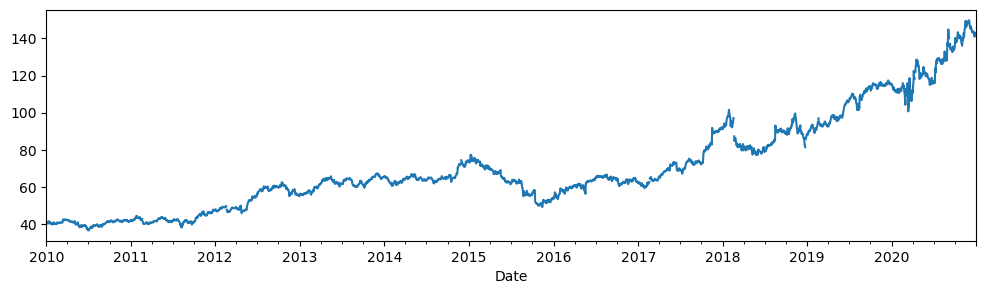

In [7]:
#We will use data from 2010 to 2020
ts = ts.loc['2010':'2020', 'Adj Close']
ts.plot()

In [8]:
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [9]:
#Make a datetime index using the Date column with a business day frequency 'B'
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [10]:
# Check for nulls
ts.isna().sum()

101

In [11]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
2011-02-21   NaN
2011-04-22   NaN
2011-05-30   NaN
2011-07-04   NaN
2011-09-05   NaN
2011-11-24   NaN
2011-12-26   NaN
2012-01-02   NaN
2012-01-16   NaN
2012-02-20   NaN
Name: Adj Close, dtype: float64

In [12]:
null = ts.isna()
ts[null].tail(20)

Date
2018-12-05   NaN
2018-12-25   NaN
2019-01-01   NaN
2019-01-21   NaN
2019-02-18   NaN
2019-04-19   NaN
2019-05-27   NaN
2019-07-04   NaN
2019-09-02   NaN
2019-11-28   NaN
2019-12-25   NaN
2020-01-01   NaN
2020-01-20   NaN
2020-02-17   NaN
2020-04-10   NaN
2020-05-25   NaN
2020-07-03   NaN
2020-09-07   NaN
2020-11-26   NaN
2020-12-25   NaN
Name: Adj Close, dtype: float64

Looks like alot of dates missing, maybe from covid? not sure if best to fill or delete and would ask an expert in real life. 

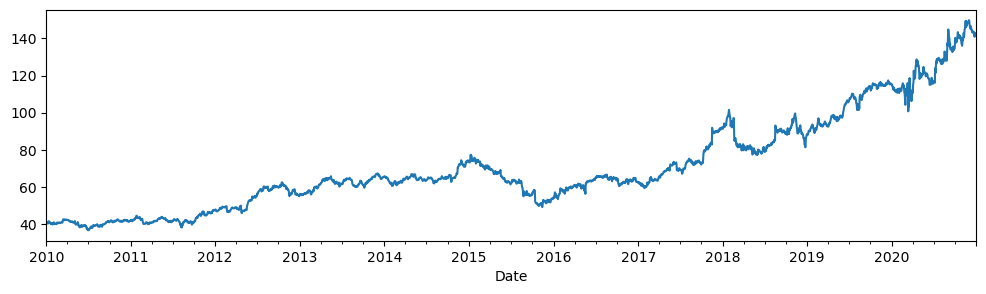

In [13]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();

In [14]:
null = ts.isna().sum()
null

1

In [15]:
ts = ts.dropna()

In [16]:
null = ts.isna().sum()
null

0

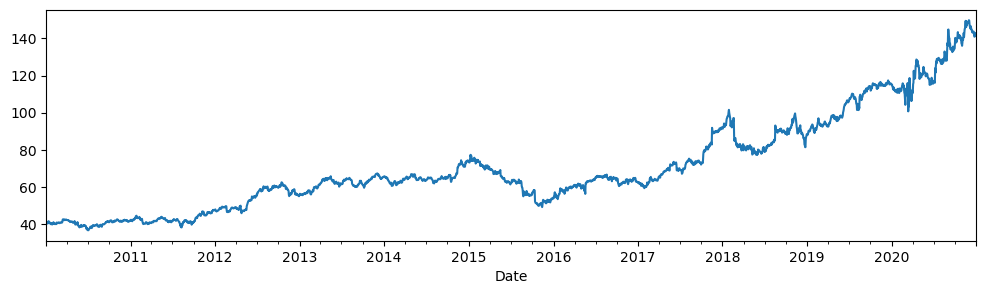

In [17]:
ts.plot();

In [18]:
#Check the time series for stationarity.
get_adfuller_results(ts)

Test Statistic  # of Lags Used  # of Observations   p-value  alpha  \
adfuller        1.436262              23               2845  0.997273   0.05   

          sig/stationary?  
adfuller            False

In [19]:
#Determine the number of differencing d needed to make the data stationary.
#We recommend using pmdarima's ndiffs
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


In [20]:
# Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ p,d,q
ts_diff1 = ts.diff().diff().dropna()

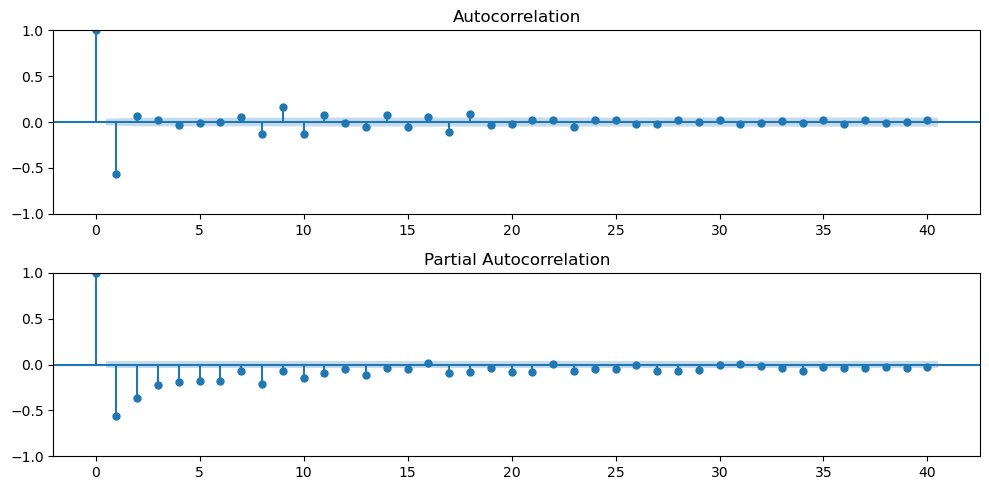

In [21]:
plot_acf_pacf(ts_diff1);

In [22]:
#Split the time series into training and test data. 
#Use a test_size of one quarter: 13 weeks X 5 business days
# Calculating number of test lags
n_test_lags = 5*13

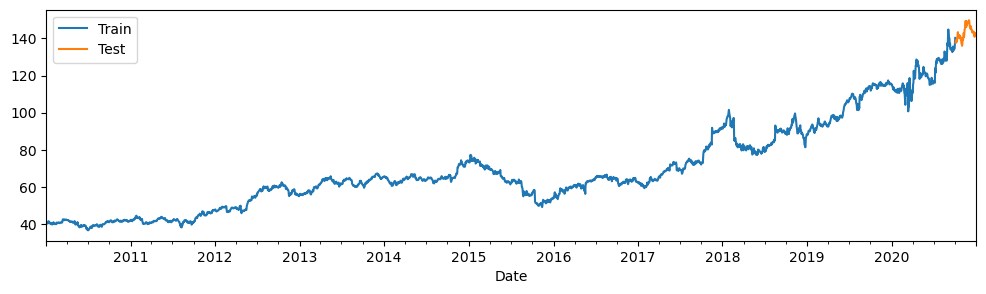

In [23]:
# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [24]:
#Fit an ARIMA model based on the orders determined during your exploration.
# Build the model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q = 2 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()


In [25]:
#Make forecasts with your model.
#Plot the forecasts versus the test data.

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.724
- MSE = 22.121
- RMSE = 4.703
- R^2 = -0.720
- MAPE = 2.56%


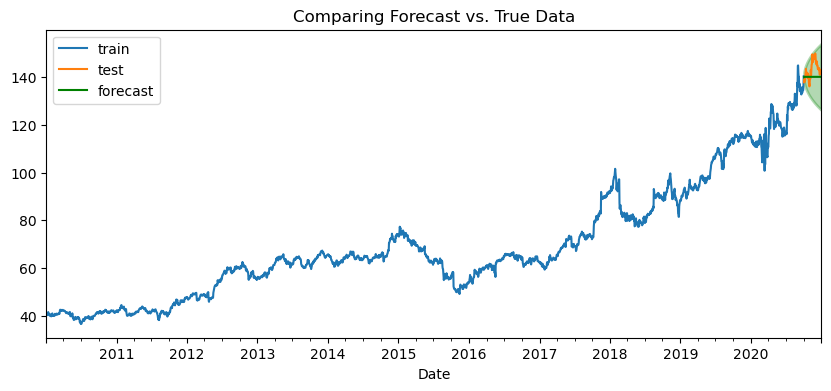

In [26]:
#Obtain metrics for evaluation.
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [27]:
#Try at least one variation of the model for comparison, 
#we recommend using a loop to try combinations of model orders
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3887.576
Date:                Wed, 10 Jan 2024   AIC                           7781.153
Time:                        15:52:09   BIC                           7798.968
Sample:                    01-04-2010   HQIC                          7787.583
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1180      0.006    -19.230      0.000      -0.130      -0.106
ma.L2          0.0231      0.006      3.685      0.000       0.011       0.035
sigma2         0.9380      0.006    147.571      0.000       0.926       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            114231.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

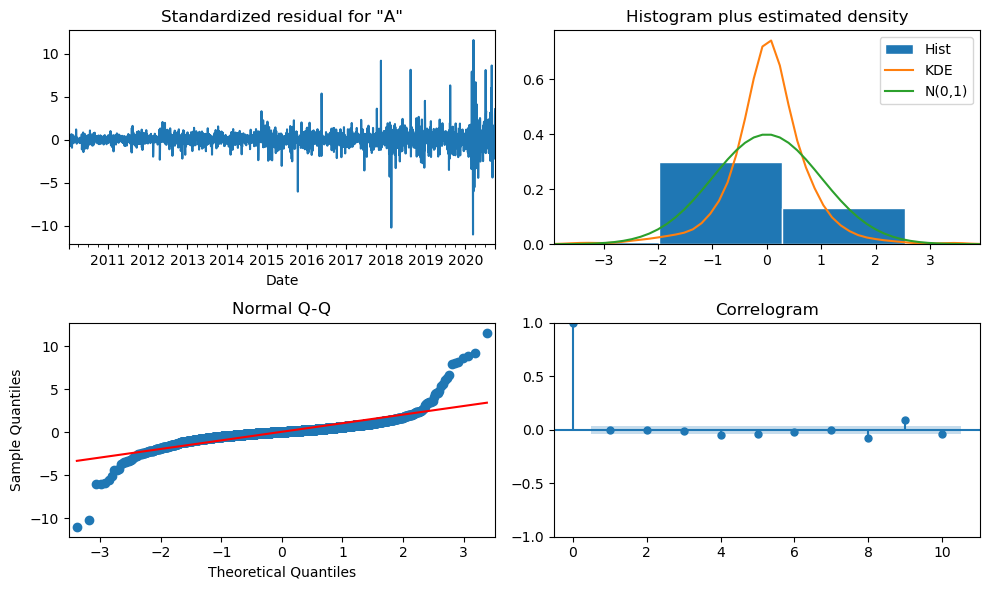

In [28]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [29]:
#Loop to Try Different Orders
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 5)  
d_values = [1]          
q_values = range(0, 5)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

In [30]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7817.4204384338
(0, 1, 1) 7780.48278476243
(0, 1, 2) 7781.152992998081
(0, 1, 3) 7782.824310533464
(0, 1, 4) 7777.05528544864
(1, 1, 0) 7779.3218305889195
(1, 1, 1) 7781.144092878053
(1, 1, 2) 7781.9434508626955
(1, 1, 3) 7778.2344064854715
(1, 1, 4) 7776.500703598105
(2, 1, 0) 7781.127658164607
(2, 1, 1) 7783.302024788493


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7783.305210561528
(2, 1, 3) 7769.195764127727


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 4) 7772.317728373501
(3, 1, 0) 7783.106545939088
(3, 1, 1) 7785.127596608432


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7771.544984361613


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) 7771.207915499571


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4) 7768.274174026188
(4, 1, 0) 7780.128581554337
(4, 1, 1) 7776.167386761541


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2) 7771.138210472021
(4, 1, 3) 7765.864198754574


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4) 7758.063165375849
Best AIC: 7758.063165375849
Best pdq: (4, 1, 4)


In [38]:
# Build the model with the best AIC
p = 4  # AR component 

d = 1  # Number of differencing required to make stationary

q = 4 # MA component 

# Define and fit the model
ar_4_ma_4_model = tsa.ARIMA(train, order=(p,d,q)).fit()

C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
ar_4_ma_4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -3870.032
Date:                Wed, 10 Jan 2024   AIC                           7758.063
Time:                        15:56:26   BIC                           7811.509
Sample:                    01-04-2010   HQIC                          7777.354
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2092      0.100     -2.086      0.037      -0.406      -0.013
ar.L2          1.1198      0.119      9.375      0.000       0.886       1.354
ar.L3          0.0022      0.064      0.035      0.972      -0.124       0.128
ar.L4         -0.6811      0.075     -9.059      0.000      -0.829      -0.534
ma.L1          0.1178      0.103      1.144      0.253      -0.084       0.320
ma.L2         -1.1273      0.113     -9.991      0.000      -1.348      -0.906
ma.L3          0.0506      0.070      0.722      0.470      -0.087       0.188
ma.L4          0.6274      0.079      7.987      0.000       0.473       0.781
sigma2         0.9267      0.008    113.271      0.000       0.911       0.943
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):             86812.30
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              10.17   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

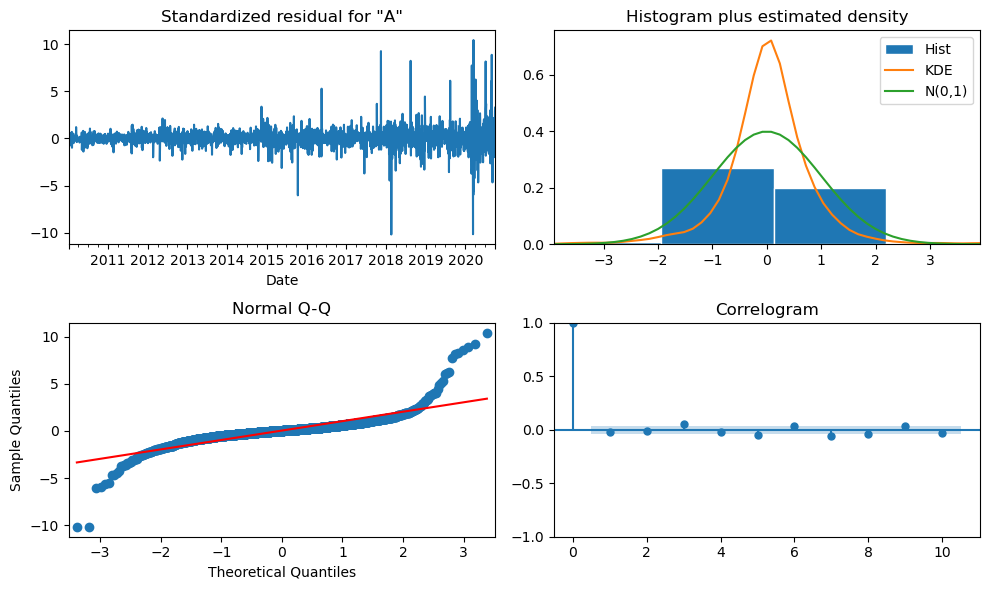

In [41]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.914
- MSE = 23.949
- RMSE = 4.894
- R^2 = -0.862
- MAPE = 2.69%


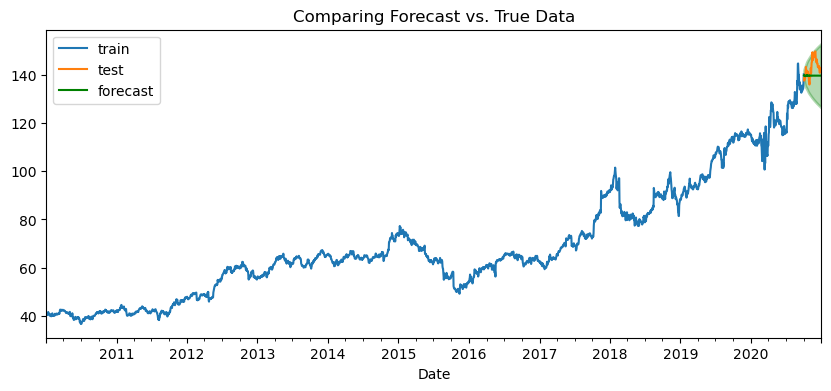

In [43]:
# Obtain summary of forecast as dataframe
forecast_df = ar_4_ma_4_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [44]:
#Seeing if I can get lower MAPE
#Loop to Try Different Orders
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 7)  
d_values = [1]          
q_values = range(0, 7)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6)]

In [45]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7817.4204384338
(0, 1, 1) 7780.48278476243
(0, 1, 2) 7781.152992998081
(0, 1, 3) 7782.824310533464
(0, 1, 4) 7777.05528544864
(0, 1, 5) 7777.036488294614
(0, 1, 6) 7778.57663753498
(1, 1, 0) 7779.3218305889195
(1, 1, 1) 7781.144092878053
(1, 1, 2) 7781.9434508626955
(1, 1, 3) 7778.2344064854715
(1, 1, 4) 7776.500703598105
(1, 1, 5) 7776.223507710034
(1, 1, 6) 7769.276210640628
(2, 1, 0) 7781.127658164607
(2, 1, 1) 7783.302024788493


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7783.305210561528
(2, 1, 3) 7769.195764127727


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 4) 7772.317728373501
(2, 1, 5) 7774.031653454742
(2, 1, 6) 7726.348908831937
(3, 1, 0) 7783.106545939088
(3, 1, 1) 7785.127596608432


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7771.544984361613


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) 7771.207915499571


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4) 7768.274174026188


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5) 7758.829952803413
(3, 1, 6) 7726.598234689058
(4, 1, 0) 7780.128581554337
(4, 1, 1) 7776.167386761541


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2) 7771.138210472021
(4, 1, 3) 7765.864198754574


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4) 7758.063165375849


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5) 7749.434623975163


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 6) 7728.5985521871335
(5, 1, 0) 7777.382192813556
(5, 1, 1) 7777.49962189916
(5, 1, 2) 7773.83537551203


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 3) 7768.087738687778


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4) 7757.537331831665


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5) 7755.489252217679


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 6) 7732.960413483335
(6, 1, 0) 7777.857221528031
(6, 1, 1) 7779.8986877249345
(6, 1, 2) 7724.689531880803


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(6, 1, 3) 7766.868580787197


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(6, 1, 4) 7745.990104360431


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(6, 1, 5) 7726.283386244287


C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12103\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(6, 1, 6) 7736.70201195489
Best AIC: 7724.689531880803
Best pdq: (6, 1, 2)


In [82]:
# Build the model with the best AIC
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q = 2 # MA component 

# Define and fit the model
ar_0_ma_2_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [83]:
ar_0_ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3887.576
Date:                Wed, 10 Jan 2024   AIC                           7781.153
Time:                        16:21:24   BIC                           7798.968
Sample:                    01-04-2010   HQIC                          7787.583
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1180      0.006    -19.230      0.000      -0.130      -0.106
ma.L2          0.0231      0.006      3.685      0.000       0.011       0.035
sigma2         0.9380      0.006    147.571      0.000       0.926       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            114231.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

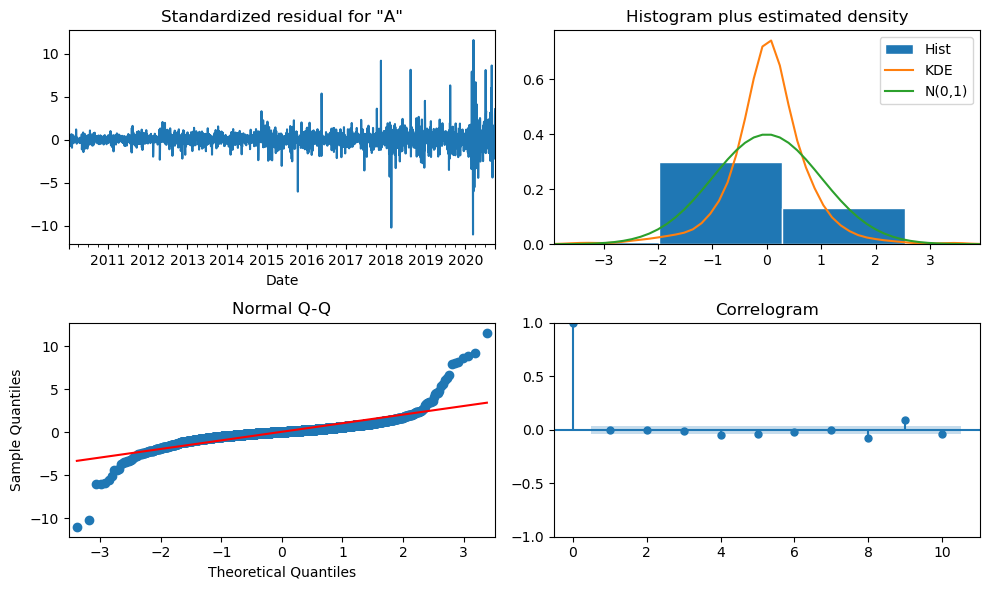

In [84]:
# Obtain diagnostic plots
fig = ar_0_ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.724
- MSE = 22.121
- RMSE = 4.703
- R^2 = -0.720
- MAPE = 2.56%


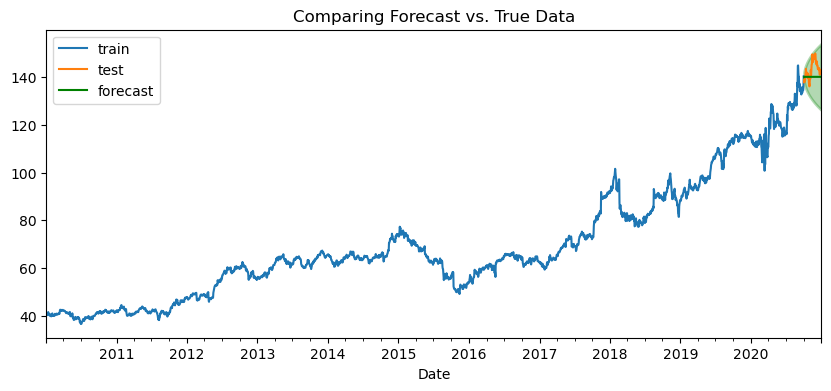

In [85]:
# Obtain summary of forecast as dataframe
forecast_df = ar_0_ma_2_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

- Choose a final model and explain:
  - How good was your model, according to your Mean Absolute Percentage Error?
  - How good was your model in terms of how well the forecast seems to follow the test data, visually?  Hint: You may want to plot fewer training data lags to see this

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.724
- MSE = 22.121
- RMSE = 4.703
- R^2 = -0.720
- MAPE = 2.56%


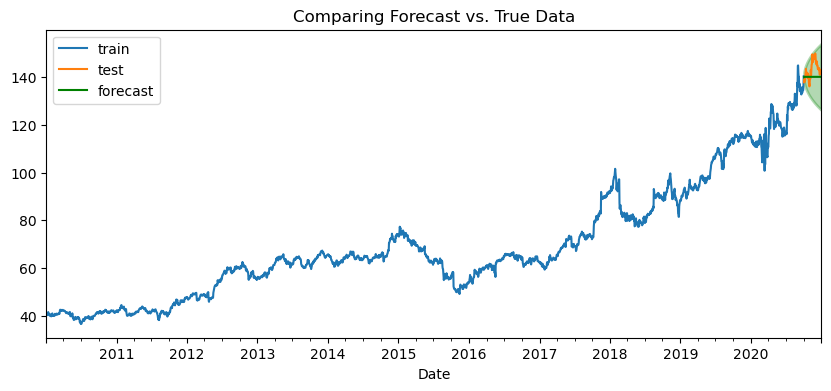

In [86]:
# The model I chose based on MAPE
forecast_df = ar_0_ma_2_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

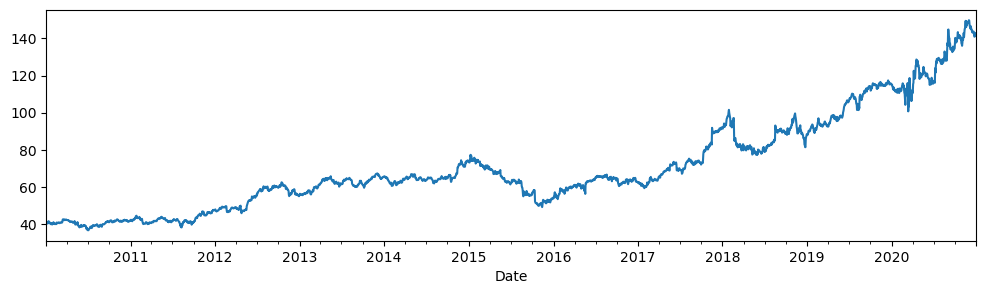

In [88]:
ts.plot();

I chose this model for the MAPE of 2.56. I may work with it more if I have time. It does seem to follow the original data very well visually. 